In [1]:
import joblib
import pandas as pd
import numpy as np
import logging

FORMAT = "%(asctime)s %(message)s"
logging.basicConfig(level="INFO", format=FORMAT, datefmt="%d-%b-%y %H:%M:%S")


def load_data():
    try:
        path = "/Users/edeno/Downloads/"
        position_info = pd.read_pickle(path + "Jaq_03_16_position_info.pkl")
        spikes = pd.read_pickle(path + "Jaq_03_16_spikes.pkl")
        is_ripple = pd.read_pickle(path + "Jaq_03_16_is_ripple.pkl")
        env = joblib.load(path + "Jaq_03_16_environment.pkl")

        time = np.asarray(position_info.index / np.timedelta64(1, "s"))
        spikes = np.asarray(spikes).astype(float)
        spikes = (spikes > 0).astype(int)
        spike_times = [time[spike.astype(bool)] for spike in spikes.T]
        position = np.asarray(position_info.linear_position).astype(float)
        position2D = np.asarray(position_info[["nose_x", "nose_y"]]).astype(float)
        is_ripple = np.asarray(is_ripple).squeeze()
        speed = np.asarray(position_info.nose_vel).astype(float)
    except FileNotFoundError:
        path = "/cumulus/edeno/non_local_paper/notebooks/"
        position_info = pd.read_pickle(path + "Jaq_03_16_position_info.pkl")
        spikes = pd.read_pickle(path + "Jaq_03_16_spikes.pkl")
        spikes = (spikes > 0).astype(int)
        spike_times = [time[spike.astype(bool)] for spike in spikes.T]
        is_ripple = pd.read_pickle(path + "Jaq_03_16_is_ripple.pkl")
        env = joblib.load(path + "Jaq_03_16_environment.pkl")

        time = np.asarray(position_info.index / np.timedelta64(1, "s"))
        spikes = np.asarray(spikes).astype(float)
        position = np.asarray(position_info.linear_position).astype(float)
        position2D = np.asarray(position_info[["nose_x", "nose_y"]]).astype(float)
        is_ripple = np.asarray(is_ripple).squeeze()
        speed = np.asarray(position_info.nose_vel).astype(float)

    return is_ripple, spikes, position, speed, env, time, position2D

In [2]:
is_ripple, spikes, position, speed, env, time, position2D = load_data()
spikes = (spikes > 0).astype(int)
spike_times = [time[spike.astype(bool)] for spike in spikes.T]


sampling_frequency = 500
time_range = (time[0], time[-1] + (1 / sampling_frequency))

n_time_bins = int((time_range[-1] - time_range[0]) * sampling_frequency) + 1
t = time_range[0] + np.arange(n_time_bins) / sampling_frequency

np.allclose(t, time)

01-Jul-25 06:02:30 Cupy is not installed or GPU is not detected. Ignore this message if not using GPU
/Users/edeno/miniconda3/envs/non_local_detector2/lib/python3.12/site-packages/replay_trajectory_classification/likelihoods/multiunit_likelihood.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


True

In [3]:
env

Environment(environment_name='', place_bin_size=2.0, track_graph=<networkx.classes.graph.Graph object at 0x11a320fe0>, edge_order=[(0, 1), (1, 2), (2, 3), (1, 4), (4, 5)], edge_spacing=[15, 0, 15, 0], is_track_interior=None, position_range=None, infer_track_interior=True, fill_holes=False, dilate=False, bin_count_threshold=0)

In [4]:
from non_local_detector import Environment

new_env = Environment.from_graph(
    graph=env.track_graph,
    edge_order=env.edge_order,
    edge_spacing=env.edge_spacing,
    bin_size=env.place_bin_size,
)

/Users/edeno/miniconda3/envs/non_local_detector2/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


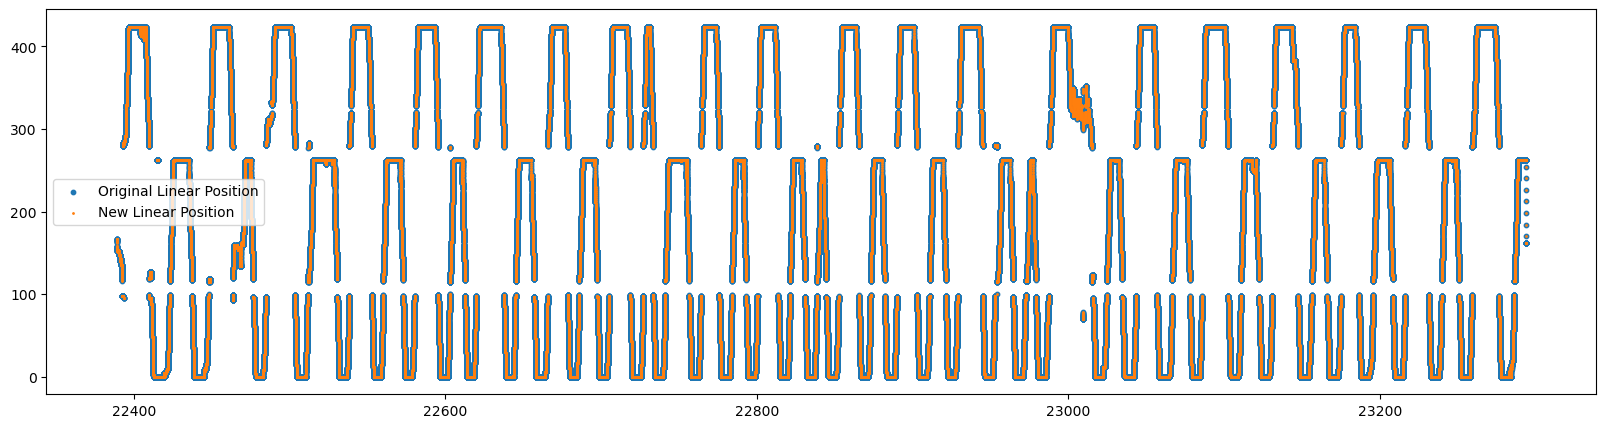

In [5]:
from track_linearization import get_linearized_position
import matplotlib.pyplot as plt

linear_pos = get_linearized_position(
    position=position2D,
    track_graph=env.track_graph,
    edge_order=env.edge_order,
    edge_spacing=env.edge_spacing,
).linear_position.to_numpy()
linear_pos2 = new_env.to_linear(position2D)


plt.figure(figsize=(20, 5))
plt.scatter(time, linear_pos, label="Original Linear Position", s=10)
plt.scatter(time, linear_pos2, label="New Linear Position", s=1)
plt.legend()
plt.show()

In [6]:
linear_pos2.shape, linear_pos.shape, time.shape

((452325,), (452325,), (452325,))

In [7]:
from non_local_detector import NonLocalSortedSpikesDetector

detector = NonLocalSortedSpikesDetector(
    environments=[new_env],
    sorted_spikes_algorithm="sorted_spikes_kde",
    sorted_spikes_algorithm_params={
        "position_std": np.sqrt(12.5),
        "block_size": int(2**12),
    },
).fit(time, position2D, spike_times, is_training=~is_ripple)

01-Jul-25 06:02:46 Fitting initial conditions...
01-Jul-25 06:02:46 Fitting discrete state transition
01-Jul-25 06:02:46 Fitting continuous state transition...
01-Jul-25 06:02:46 Fitting place fields...
01-Jul-25 06:02:48 Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
01-Jul-25 06:02:48 Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/edeno/miniconda3/envs/non_local_detector2/lib/python3.12/site-packages/jaxlib/../../../libtpu.so' (no such file), '/Users/edeno/miniconda3/envs/non_local_detector2/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)


Encoding models:   0%|          | 0/104 [00:00<?, ?cell/s]

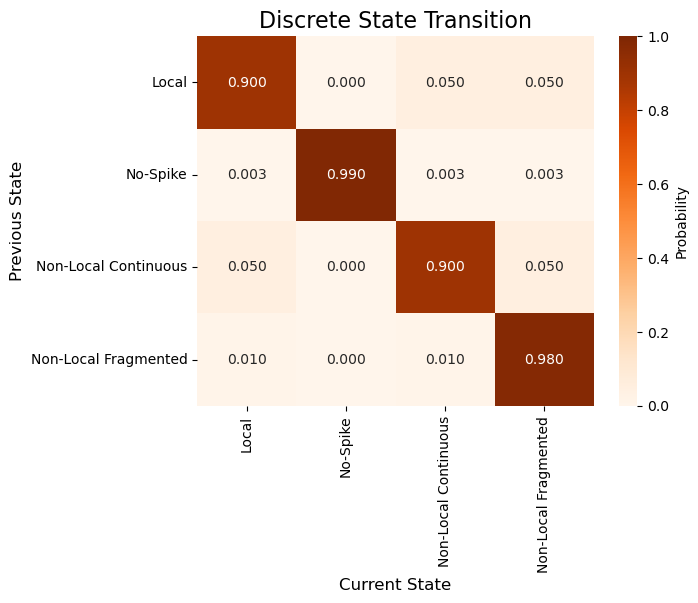

In [8]:
detector.plot_discrete_state_transition()

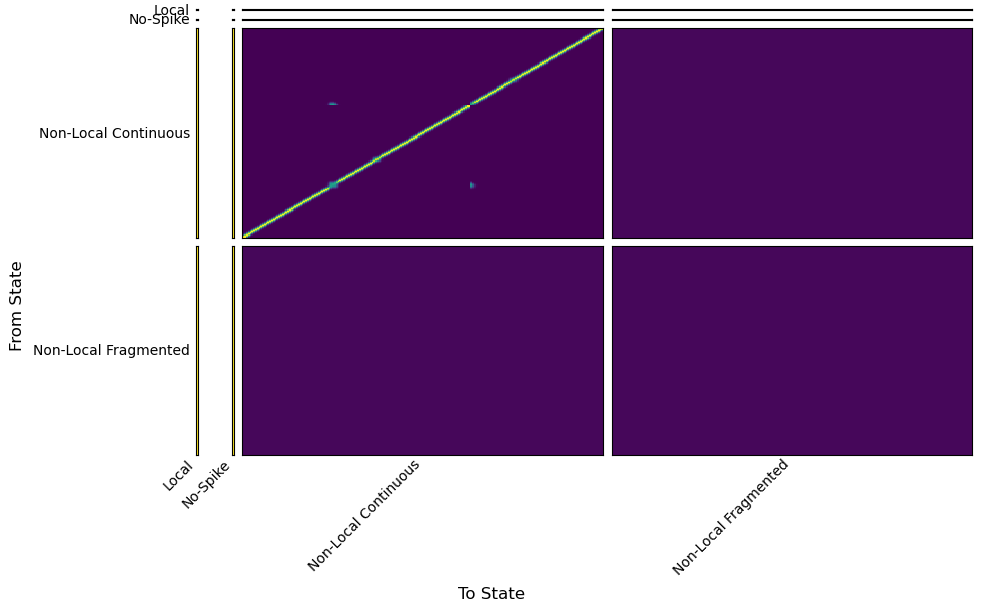

In [9]:
detector.plot_continuous_state_transition()

/Users/edeno/miniconda3/envs/non_local_detector2/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  func(*args, **kwargs)
/Users/edeno/miniconda3/envs/non_local_detector2/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


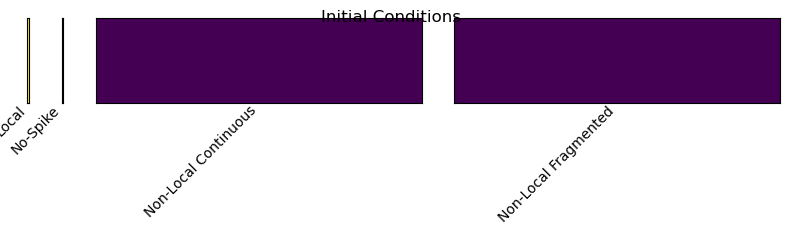

In [10]:
detector.plot_initial_conditions()

In [11]:
results = detector.predict(spike_times, time, position2D, time)
results

01-Jul-25 06:03:18 Computing posterior...
01-Jul-25 06:03:18 Computing log likelihood...


Local Likelihood:   0%|          | 0/104 [00:00<?, ?cell/s]

No Spike Likelihood:   0%|          | 0/104 [00:00<?, ?cell/s]

Non-Local Likelihood:   0%|          | 0/104 [00:00<?, ?cell/s]

/Users/edeno/Documents/GitHub/non_local_detector/src/non_local_detector/models/base.py:1200: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'state_bins' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  results = xr.Dataset(


<xarray.Dataset> Size: 742MB
Dimensions:                      (time: 452325, state_bins: 404, states: 4,
                                  state_ind: 404)
Coordinates:
  * time                         (time) float64 4MB 2.239e+04 ... 2.329e+04
  * state_bins                   (state_bins) object 3kB MultiIndex
  * state                        (state_bins) object 3kB 'Local' ... 'Non-Loc...
  * position                     (state_bins) float64 3kB nan nan ... 422.7
  * state_ind                    (state_ind) int64 3kB 0 1 2 2 2 2 ... 3 3 3 3 3
  * states                       (states) <U20 320B 'Local' ... 'Non-Local Fr...
    environments                 (states) <U1 16B '' '' '' ''
    encoding_groups              (states) int64 32B 0 0 0 0
Data variables:
    acausal_posterior            (time, state_bins) float32 731MB 1.0 ... 0.0...
    acausal_state_probabilities  (time, states) float32 7MB 1.0 ... 0.3953
Attributes:
    marginal_log_likelihoods:  -1917166.4

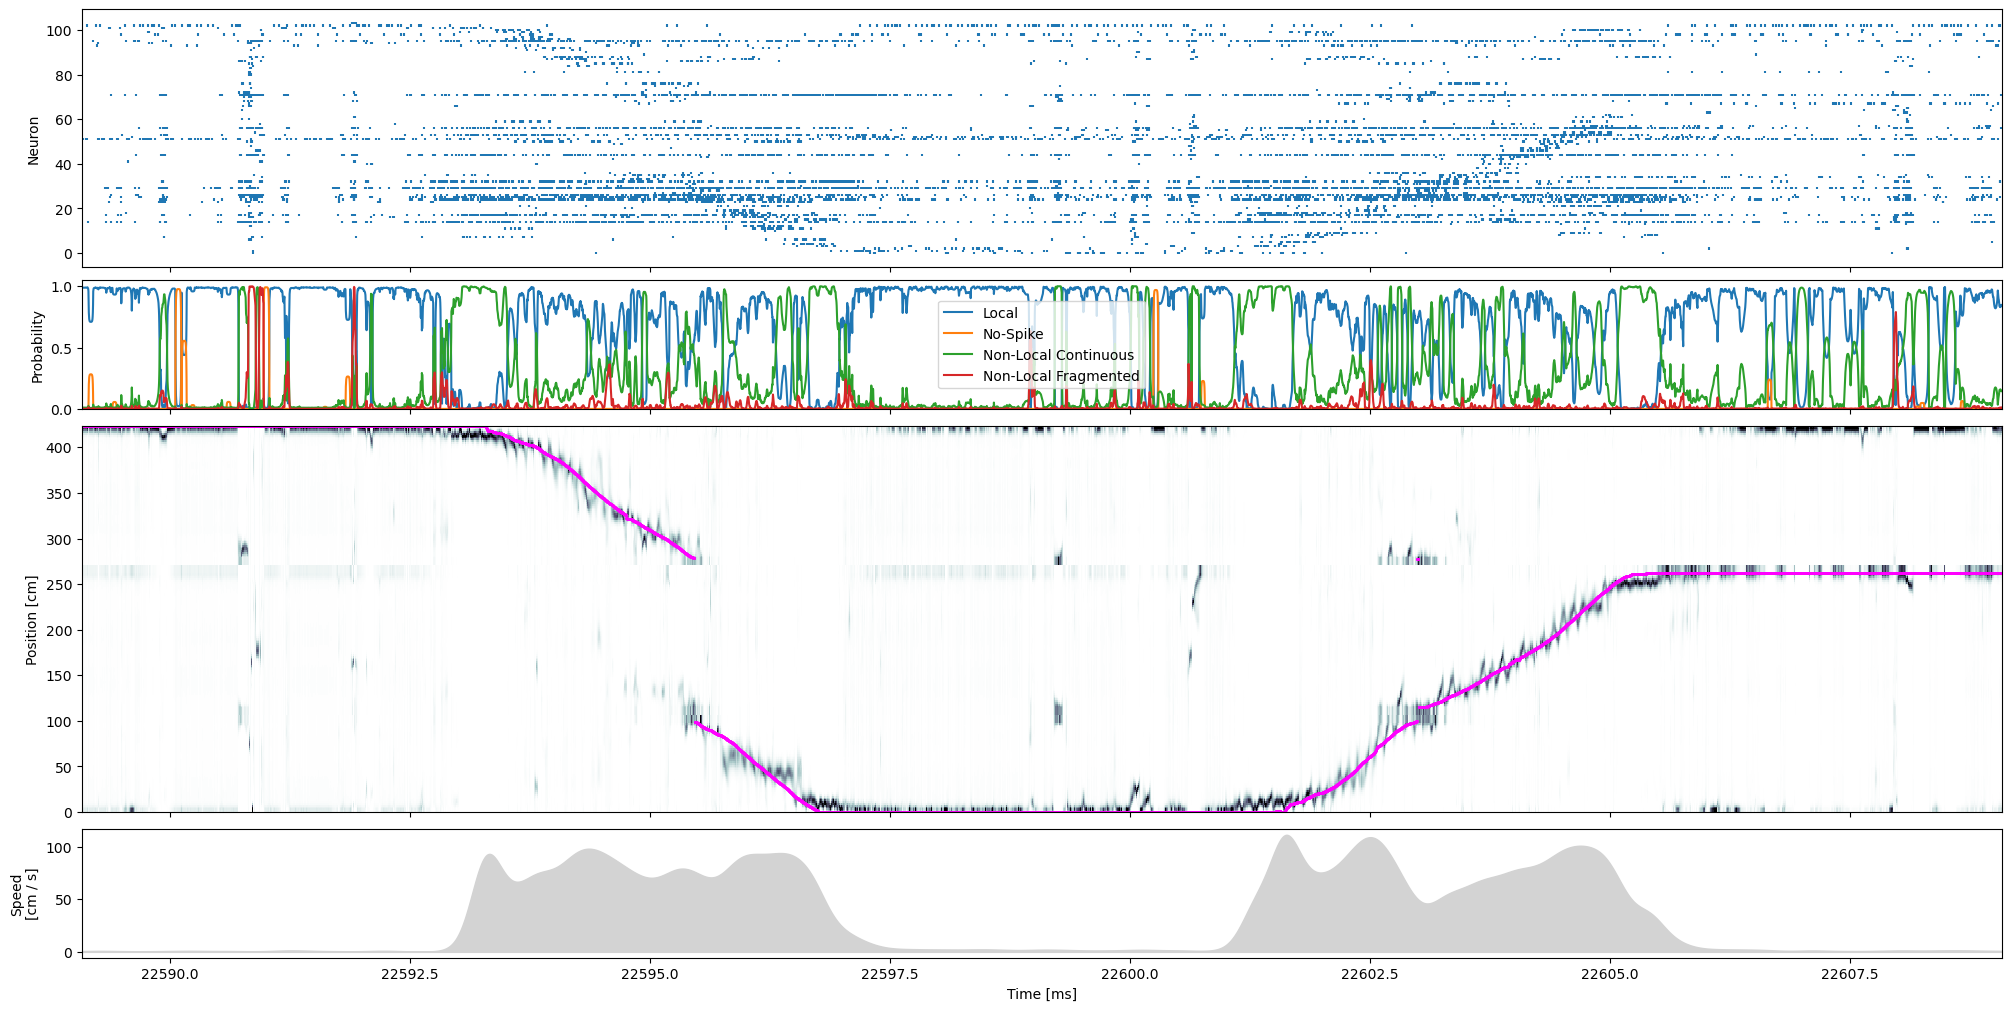

In [ ]:
from non_local_detector.visualization import plot_non_local_model



plot_non_local_model(
    time,
    position2D,
    spike_times,
    speed,
    detector,
    results,
    time_slice=slice(time[100_000], time[110_000]),
    figsize=(20, 10),
)

In [ ]:
# from non_local_detector import NonLocalSortedSpikesDetector


# detector = NonLocalSortedSpikesDetector(
#     environments=new_env,
#     sorted_spikes_algorithm="sorted_spikes_kde",
#     sorted_spikes_algorithm_params={
#         "position_std": np.sqrt(12.5),
#         "block_size": int(2**12),
#     },
# )
# detector.estimate_parameters(
#     time=time[:100],
#     position_time=time[:100],
#     position=position2D[:100],
#     spike_times=spike_times,
#     is_training=~is_ripple[:100],
# )

In [ ]:
from non_local_detector import SortedSpikesDecoder

decoder = SortedSpikesDecoder(
    environments=new_env,
    sorted_spikes_algorithm="sorted_spikes_kde",
    sorted_spikes_algorithm_params={
        "position_std": np.sqrt(12.5),
        "block_size": int(2**12),
    },
).fit(time, position2D, spike_times, is_training=~is_ripple)
results2 = decoder.predict(
    spike_times=spike_times,
    time=time
)

In [ ]:
t, x = np.meshgrid(results2.sel(time=time_slice).time.values, new_env.to_linear(new_env.bin_centers))
plt.pcolormesh(
    t,
    x,
    results2.acausal_posterior.sel(time=time_slice).values.T,
    vmin=0.0,
    cmap="bone_r",
)
time_slice_ind = slice(
    np.searchsorted(results2.time.values, time_slice.start),
    np.searchsorted(results2.time.values, time_slice.stop),
)
plt.scatter(
    time[time_slice_ind],
    new_env.to_linear(position2D[time_slice_ind]),
    s=1,
    color="magenta",
    zorder=2,

)

In [ ]:
results2

In [ ]:
from track_linearization import plot_track_graph

place_fields = decoder.encoding_model_[("", 0)]["place_fields"]
neuron_ind = 4

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(position2D[:, 0], position2D[:, 1], color="lightgrey", alpha=0.5)
plot_track_graph(
    new_env.linearization_properties["track_graph"],
    ax=axes[0],
)
# plot node id
for node_id, node_data in new_env.linearization_properties["track_graph"].nodes(data=True):
    axes[0].text(
        node_data["pos"][0],
        node_data["pos"][1],
        str(node_id),
        fontsize=8,
        ha="center",
        va="center",
        color="black",
    )

position_at_spike_time = position2D[np.searchsorted(time, spike_times[neuron_ind])]
axes[0].scatter(
    position_at_spike_time[:, 0],
    position_at_spike_time[:, 1],
    s=1,
    color="magenta",
    zorder=2,
)


axes[1].plot(new_env.to_linear(new_env.bin_centers), place_fields[neuron_ind])
new_env.plot_1D(ax=axes[1])
axes[1].set_xlabel("Position [cm]")
axes[1].set_ylabel("Place field [spikes / s]")
axes[1].set_title(f"Neuron {neuron_ind}")

In [ ]:
plt.plot(new_env.to_linear(new_env.bin_centers), decoder.encoding_model_[("", 0)]["occupancy"])
plt.hist(
    new_env.to_linear(position2D),
    bins=new_env.grid_edges[0],
    density=True,
)
plt.xlabel("Position [cm]")

In [ ]:
neuron_ind = 5
position_at_spike_time = position2D[np.searchsorted(time, spike_times[neuron_ind])]

marginal = decoder.encoding_model_[("", 0)]["marginal_models"][neuron_ind].predict(
    new_env.to_linear(new_env.bin_centers))

plt.figure(figsize=(20, 5))
plt.plot(new_env.to_linear(new_env.bin_centers), marginal, label="Marginal")
plt.scatter(new_env.to_linear(new_env.bin_centers), marginal, label="Marginal", s=10, color="black", zorder=10)
plt.eventplot(env.to_linear(position_at_spike_time), color="red", linelengths=0.001, lineoffsets=0.0)
plt.hist(
    env.to_linear(position_at_spike_time),
    bins=new_env.grid_edges[0],
    density=True,
    alpha=0.8,
    label="Position distribution",
    facecolor="lightgrey",
)
plt.xlabel("Position [cm]")
plt.xlim((0, 150))
for i in new_env.grid_edges[0]:
    plt.axvline(i, color="black", alpha=0.1)

In [ ]:
neuron_ind = 5
position_at_spike_time = position2D[np.searchsorted(time, spike_times[neuron_ind])]

marginal = decoder.encoding_model_[("", 0)]["marginal_models"][neuron_ind].predict(
    new_env.to_linear(new_env.bin_centers)
)

plt.figure(figsize=(20, 5))
plt.plot(new_env.to_linear(new_env.bin_centers), marginal, label="Marginal")
plt.scatter(
    new_env.to_linear(new_env.bin_centers),
    marginal,
    label="Marginal",
    s=10,
    color="black",
    zorder=10,
)
plt.eventplot(
    env.to_linear(position_at_spike_time),
    color="red",
    linelengths=0.001,
    lineoffsets=0.0,
)
plt.hist(
    env.to_linear(position_at_spike_time),
    bins=new_env.grid_edges[0],
    density=True,
    alpha=0.8,
    label="Position distribution",
    facecolor="lightgrey",
)
plt.xlabel("Position [cm]")
plt.xlim((150, 450))
for i in new_env.grid_edges[0]:
    plt.axvline(i, color="black", alpha=0.1)

In [ ]:
new_env.bin_centers[~new_env.active_mask]

In [ ]:
(~new_env.active_mask).nonzero()[0]

In [ ]:
np.diff(new_env.to_linear(new_env.bin_centers))

In [ ]:
new_env.bin_centers.shape